# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [ ]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [ ]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [ ]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [ ]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

# **Запуск базовой модели с семинара на новом датасете**

In [ ]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', num_layers: int = 1  # поддержка нескольких слоев
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        self.rnn = nn.RNN(
            hidden_dim,
            hidden_dim,
            batch_first=True,
            num_layers=num_layers
        )

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type
        self.num_layers = num_layers

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]

        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]  # [batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)    # [batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), num_classes=4, aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

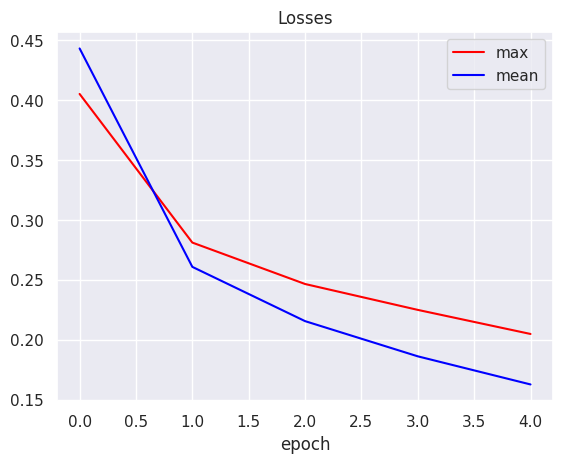

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.74
Лучшая accuracy для подхода mean: 90.76


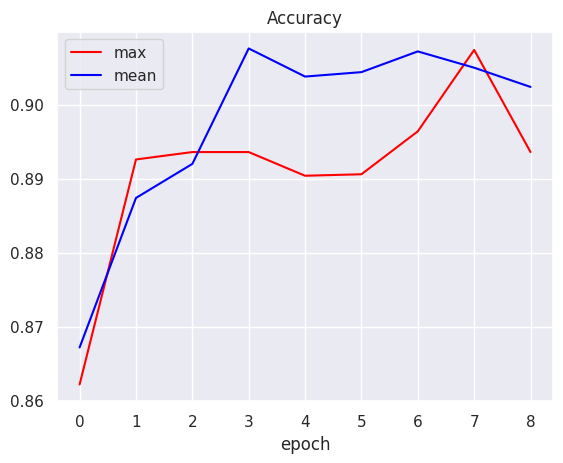

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# **Проведение экспериментов по улучшению модели**

# 1) Обучение LSTM и GRU (однослойные)

In [ ]:
class CharLMLSTM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', num_layers: int = 1, bidirectional: bool = False
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        self.lstm = nn.LSTM(
            hidden_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        self.linear = nn.Linear(hidden_dim * (2 if bidirectional else 1), hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        self.aggregation_type = aggregation_type
        self.bidirectional = bidirectional

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]

        output, (hidden, cell) = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim * num_directions]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]  # [batch_size, hidden_dim * num_directions]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)    # [batch_size, hidden_dim * num_directions]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
class CharLMGRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', num_layers: int = 1, bidirectional: bool = False, dropout: float = 0.1
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        self.gru = nn.GRU(
            hidden_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        self.linear = nn.Linear(hidden_dim * (2 if bidirectional else 1), hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout)
        self.aggregation_type = aggregation_type
        self.bidirectional = bidirectional

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]

        output, _ = self.gru(embeddings)  # [batch_size, seq_len, hidden_dim * num_directions]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]  # [batch_size, hidden_dim * num_directions]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)    # [batch_size, hidden_dim * num_directions]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
def train_model(
    model_class,
    model_name,
    train_dataloader,
    eval_dataloader,
    vocab,
    word2ind,
    device,
    num_epoch=5,
    eval_steps=None,
    aggregation_types=['max', 'mean'],
    **model_kwargs
):
    if eval_steps is None:
        eval_steps = len(train_dataloader) // 2

    losses_type = {}
    acc_type = {}
    models = {}

    for aggregation_type in aggregation_types:
        print(f"\n{'='*50}")
        print(f"Starting training for {model_name} with {aggregation_type} aggregation")
        print(f"{'='*50}")

        losses = []
        acc = []

        model = model_class(
            hidden_dim=256,
            vocab_size=len(vocab),
            num_classes=4,
            aggregation_type=aggregation_type,
            **model_kwargs
        ).to(device)

        criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
        optimizer = torch.optim.Adam(model.parameters())

        for epoch in range(num_epoch):
            epoch_losses = []
            model.train()
            for i, batch in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch}:')):
                optimizer.zero_grad()
                logits = model(batch['input_ids'])
                loss = criterion(logits, batch['label'])
                loss.backward()
                optimizer.step()

                epoch_losses.append(loss.item())
                if i % eval_steps == 0:
                    model.eval()
                    accuracy = evaluate(model, eval_dataloader)
                    acc.append(accuracy)
                    model.train()

            losses.append(sum(epoch_losses) / len(epoch_losses))

        losses_type[f"{model_name}_{aggregation_type}"] = losses
        acc_type[f"{model_name}_{aggregation_type}"] = acc
        models[f"{model_name}_{aggregation_type}"] = model

    return losses_type, acc_type, models

In [ ]:
# LSTM модель
losses_lstm, acc_lstm, models_lstm = train_model(
    model_class=CharLMLSTM,
    model_name="LSTM",
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    vocab=vocab,
    word2ind=word2ind,
    device=device,
    num_epoch=5,
)


Starting training for LSTM with max aggregation


Epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]


Starting training for LSTM with mean aggregation


Epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

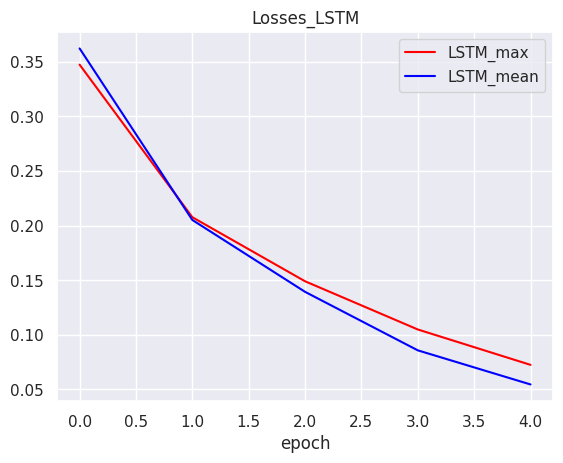

In [ ]:
for (name, values), color in zip(losses_lstm.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_lstm[name])), losses_lstm[name], color=color, label=name)

plt.title('Losses_LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода LSTM_max: 90.86
Лучшая accuracy для подхода LSTM_mean: 91.58


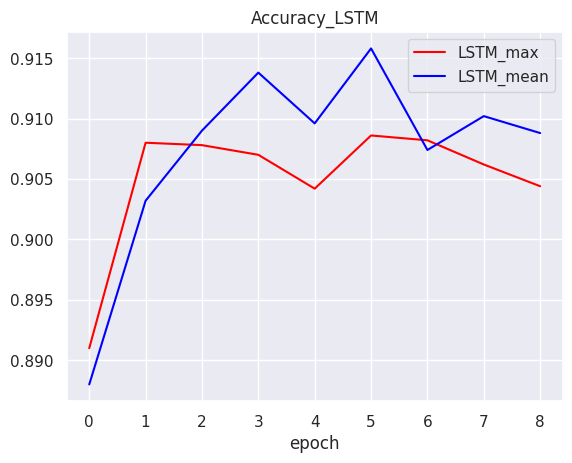

In [ ]:
for (name, values), color in zip(losses_lstm.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_lstm[name][1:])), acc_lstm[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_lstm[name]) * 100):.2f}")

plt.title('Accuracy_LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
lstm_model_max = models_lstm['LSTM_max']
lstm_model_mean = models_lstm['LSTM_mean']

accuracy_max = evaluate(lstm_model_max, eval_dataloader)
print(f"LSTM_max агрегация: {accuracy_max * 100:.2f}%")

accuracy_mean = evaluate(lstm_model_mean, eval_dataloader)
print(f"LSTM_mean агрегация: {accuracy_mean * 100:.2f}%")

LSTM_max агрегация: 90.62%
LSTM_mean агрегация: 89.84%


In [ ]:
# GRU модель
losses_gru, acc_gru, models_gru = train_model(
    model_class=CharLMGRU,
    model_name="GRU",
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    vocab=vocab,
    word2ind=word2ind,
    device=device,
    num_epoch=5,
)


Starting training for GRU with max aggregation


Epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]


Starting training for GRU with mean aggregation


Epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

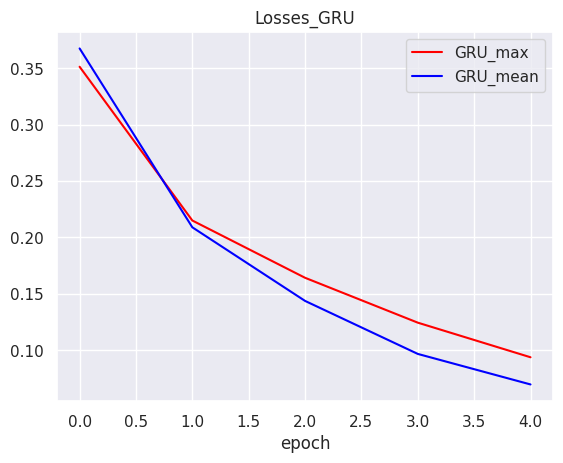

In [ ]:
for (name, values), color in zip(losses_gru.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_gru[name])), losses_gru[name], color=color, label=name)

plt.title('Losses_GRU')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода GRU_max: 91.16
Лучшая accuracy для подхода GRU_mean: 91.28


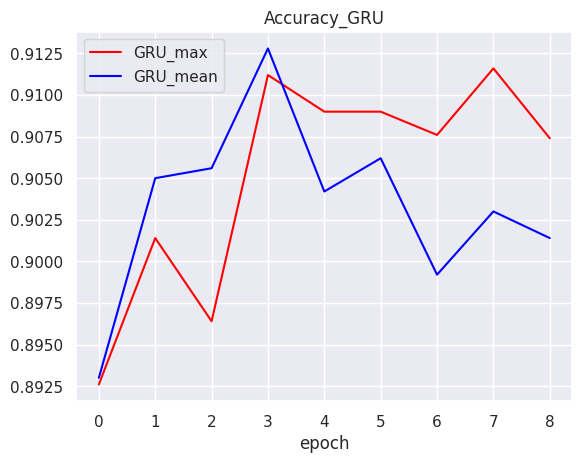

In [ ]:
for (name, values), color in zip(losses_gru.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_gru[name][1:])), acc_gru[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_gru[name]) * 100):.2f}")

plt.title('Accuracy_GRU')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
gru_model_max = models_gru['GRU_max']
gru_model_mean = models_gru['GRU_mean']

accuracy_max = evaluate(gru_model_max, eval_dataloader)
print(f"GRU_max агрегация: {accuracy_max * 100:.2f}%")

accuracy_mean = evaluate(gru_model_mean, eval_dataloader)
print(f"GRU_mean агрегация: {accuracy_mean * 100:.2f}%")

GRU_max агрегация: 90.68%
GRU_mean агрегация: 90.34%


**Продолжим работу с моделью GRU, та показала лучшее качество на нынешних параметрах, попробуем его увеличить. Конечно, не факт, что сочетание GRU и каких-то улучшений будет наилучшим решением задачи (возможно можно достичь лучшего score на другой модели RNN с другими параметрами). Но для ускорения процесса, поработаем конкретно с этой моделью.**

# 2) Увеличение количества рекуррентных слоёв модели GRU

In [ ]:
losses_gru_2layers, acc_gru_2layers, models_gru_2layers = train_model(
    model_class=CharLMGRU,
    model_name="GRU",
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    vocab=vocab,
    word2ind=word2ind,
    device=device,
    num_epoch=5,
    num_layers=2
)


Starting training for GRU with max aggregation


Epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]


Starting training for GRU with mean aggregation


Epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

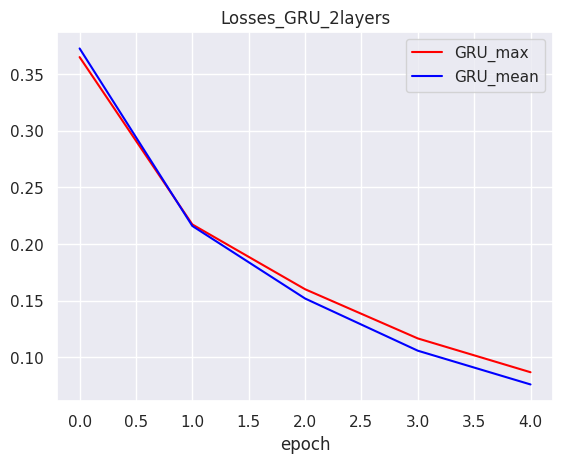

In [ ]:
for (name, values), color in zip(losses_gru_2layers.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_gru_2layers[name])), losses_gru_2layers[name], color=color, label=name)

plt.title('Losses_GRU_2layers')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода GRU_max: 91.58
Лучшая accuracy для подхода GRU_mean: 90.98


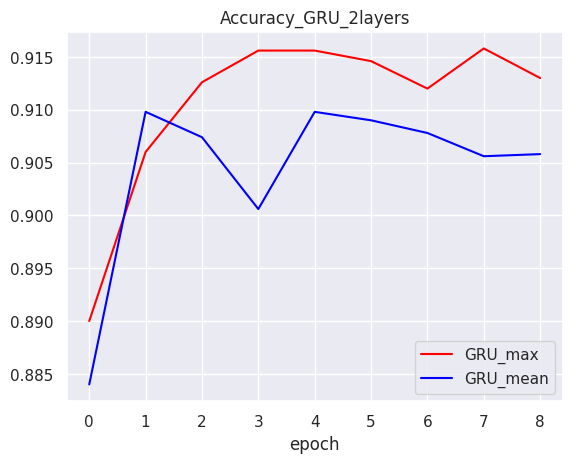

In [ ]:
for (name, values), color in zip(losses_gru_2layers.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_gru_2layers[name][1:])), acc_gru_2layers[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_gru_2layers[name]) * 100):.2f}")

plt.title('Accuracy_GRU_2layers')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
gru_model_max = models_gru_2layers['GRU_max']
gru_model_mean = models_gru_2layers['GRU_mean']

accuracy_max = evaluate(gru_model_max, eval_dataloader)
print(f"GRU_2layers_max агрегация: {accuracy_max * 100:.2f}%")

accuracy_mean = evaluate(gru_model_mean, eval_dataloader)
print(f"GRU_2layers_mean агрегация: {accuracy_mean * 100:.2f}%")

GRU_2layers_max агрегация: 90.98%
GRU_2layers_mean агрегация: 90.62%


**MAX - агрегация даёт лучшие результаты, оставим только её.**

In [ ]:
losses_gru_3layers, acc_gru_3layers, models_gru_3layers = train_model(
    model_class=CharLMGRU,
    model_name="GRU",
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    vocab=vocab,
    word2ind=word2ind,
    device=device,
    num_epoch=5,
    num_layers=3,
    aggregation_types=['max']
)


Starting training for GRU with max aggregation


Epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода GRU_max: 91.48


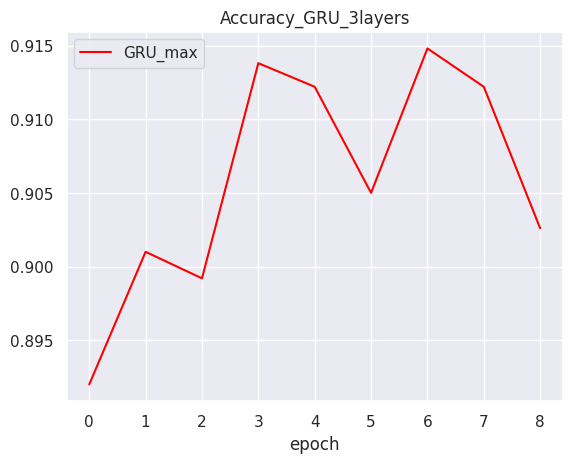

In [ ]:
for (name, values), color in zip(losses_gru_3layers.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_gru_3layers[name][1:])), acc_gru_3layers[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_gru_3layers[name]) * 100):.2f}")

plt.title('Accuracy_GRU_3layers')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
gru_model_max = models_gru_3layers['GRU_max']

accuracy_max = evaluate(gru_model_max, eval_dataloader)
print(f"GRU_3layers_max агрегация: {accuracy_max * 100:.2f}%")

GRU_3layers_max агрегация: 90.98%


1 слой
- GRU_max_1layers агрегация: 90.68%
- GRU_mean_1layers агрегация: 90.34%

2 слоя
- GRU_2layers_max агрегация: 90.98%
- GRU_2layers_mean агрегация: 90.62%

3 слоя
- GRU_3layers_max агрегация: 90.98%

# 3) Оставим модели GRU_2layers_max и GRU_1layers_max. Попробуем добавить параметр bidirectional=True.

In [ ]:
losses_gru_2layers, acc_gru_2layers, models_gru_2layers = train_model(
    model_class=CharLMGRU,
    model_name="GRU",
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    vocab=vocab,
    word2ind=word2ind,
    device=device,
    num_epoch=5,
    num_layers=2,
    aggregation_types=['max'],
    bidirectional=True
)


Starting training for GRU with max aggregation


Epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода GRU_max: 91.08


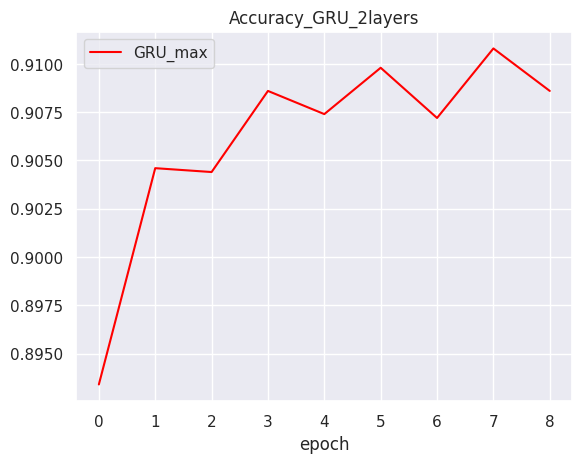

In [ ]:
for (name, values), color in zip(losses_gru_2layers.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_gru_2layers[name][1:])), acc_gru_2layers[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_gru_2layers[name]) * 100):.2f}")

plt.title('Accuracy_GRU_2layers')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
gru_model_max = models_gru_2layers['GRU_max']

accuracy_max = evaluate(gru_model_max, eval_dataloader)
print(f"GRU_2layers_max агрегация (c bidirectional=True): {accuracy_max * 100:.2f}%")

GRU_2layers_max агрегация (c bidirectional=True): 91.22%


# 4) Изменение архитектуры после применения RNN.

**Изменим немного модель: конкатенируем результат агрегации и эмбеддинг с последнего токена.**

In [ ]:
class GRU_2(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', num_layers: int = 1,
        bidirectional: bool = False, dropout: float = 0.1  # добавили параметр dropout
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        self.gru = nn.GRU(
            hidden_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        gru_output_dim = hidden_dim * (2 if bidirectional else 1)
        self.linear = nn.Linear(gru_output_dim * 2, hidden_dim)  # *2 для конкатенации
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout)
        self.aggregation_type = aggregation_type
        self.bidirectional = bidirectional
        self.gru_output_dim = gru_output_dim

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]

        output, _ = self.gru(embeddings)  # [batch_size, seq_len, gru_output_dim]

        # Конкатенируем агрегацию и последний токен
        if self.aggregation_type == 'max':
            aggregated = output.max(dim=1)[0]  # [batch_size, gru_output_dim]
        elif self.aggregation_type == 'mean':
            aggregated = output.mean(dim=1)    # [batch_size, gru_output_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        last_token = output[:, -1, :]          # [batch_size, gru_output_dim] - последний токен

        combined = torch.cat([aggregated, last_token], dim=1)  # [batch_size, gru_output_dim * 2]

        output = self.dropout(self.linear(self.non_lin(combined)))
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
losses_gru_2_2layers_, acc_gru_2_2layers, models_gru_2_2layers = train_model(
    model_class=GRU_2,
    model_name="GRU",
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    vocab=vocab,
    word2ind=word2ind,
    device=device,
    num_epoch=5,
    num_layers=2,
    aggregation_types=['max'],
    bidirectional=True
)


Starting training for GRU with max aggregation


Epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

In [ ]:
gru_model_max = models_gru_2_2layers['GRU_max']

accuracy_max = evaluate(gru_model_max, eval_dataloader)
print(f"GRU_2_2layers_max агрегация: {accuracy_max * 100:.2f}%")

GRU_2_2layers_max агрегация: 91.02%


Качество стало хуже при такой агреграции max + last.

In [ ]:
class GRU_3(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', num_layers: int = 1,
        bidirectional: bool = False, dropout: float = 0.1
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        self.gru = nn.GRU(
            hidden_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        gru_output_dim = hidden_dim * (2 if bidirectional else 1)

        if aggregation_type == 'combined':
            # Для комбинированной: max + mean + last = 3 * gru_output_dim
            self.linear = nn.Linear(gru_output_dim * 3, hidden_dim)
        else:
            # Для обычных: gru_output_dim * 2 (агрегация + last)
            self.linear = nn.Linear(gru_output_dim * 2, hidden_dim)

        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout)
        self.aggregation_type = aggregation_type
        self.bidirectional = bidirectional
        self.gru_output_dim = gru_output_dim

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.gru(embeddings)  # [batch_size, seq_len, gru_output_dim]

        if self.aggregation_type == 'combined':
            max_pooled = output.max(dim=1)[0]    # [batch_size, gru_output_dim]
            mean_pooled = output.mean(dim=1)     # [batch_size, gru_output_dim]
            last_token = output[:, -1, :]        # [batch_size, gru_output_dim]

            # Конкатенируем все три
            combined = torch.cat([max_pooled, mean_pooled, last_token], dim=1)  # [batch_size, gru_output_dim * 3]

        elif self.aggregation_type == 'max':
            aggregated = output.max(dim=1)[0]    # [batch_size, gru_output_dim]
            last_token = output[:, -1, :]        # [batch_size, gru_output_dim]
            combined = torch.cat([aggregated, last_token], dim=1)  # [batch_size, gru_output_dim * 2]

        elif self.aggregation_type == 'mean':
            aggregated = output.mean(dim=1)      # [batch_size, gru_output_dim]
            last_token = output[:, -1, :]        # [batch_size, gru_output_dim]
            combined = torch.cat([aggregated, last_token], dim=1)  # [batch_size, gru_output_dim * 2]

        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(combined)))
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

**Рассмотрим агрегацию max + mean + last**

In [ ]:
losses_gru_3_2layers_, acc_gru_3_2layers, models_gru_3_2layers = train_model(
    model_class=GRU_3,
    model_name="GRU",
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    vocab=vocab,
    word2ind=word2ind,
    device=device,
    num_epoch=5,
    num_layers=2,
    aggregation_types=['combined'],
    bidirectional=True
)


Starting training for GRU with combined aggregation


Epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

In [ ]:
gru_model_combined = models_gru_3_2layers['GRU_combined']

accuracy_combined = evaluate(gru_model_combined, eval_dataloader)
print(f"GRU_3_2layers_combined агрегация: {accuracy_combined * 100:.2f}%")

GRU_3_2layers_combined агрегация: 90.78%


Как видим, лучшее качество у двухслойной сети при max-агрегации.



Рассмотрим однослойную сеть и max+mean+last агрегацию.

In [ ]:
losses_gru_3_1layers_, acc_gru_3_1layers, models_gru_3_1layers = train_model(
    model_class=GRU_3,
    model_name="GRU",
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    vocab=vocab,
    word2ind=word2ind,
    device=device,
    num_epoch=5,
    num_layers=1,
    aggregation_types=['combined'],
    bidirectional=True
)


Starting training for GRU with combined aggregation


Epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода GRU_combined: 92.00


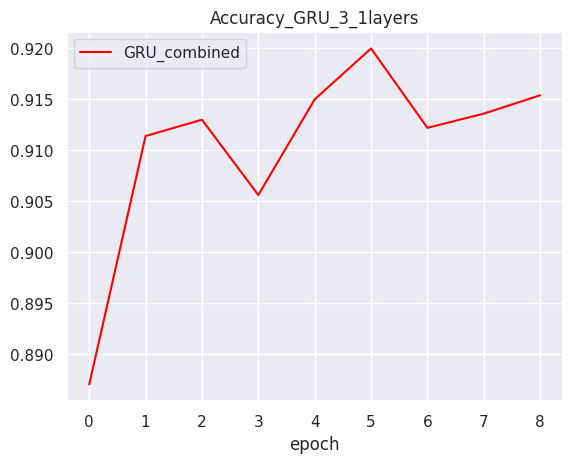

In [ ]:
for (name, values), color in zip(losses_gru_3_1layers_.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_gru_3_1layers[name][1:])), acc_gru_3_1layers[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_gru_3_1layers[name]) * 100):.2f}")

plt.title('Accuracy_GRU_3_1layers')
plt.xlabel("epoch")
plt.legend()
plt.show()

# **# Лучшая модель на данный момент**

In [ ]:
gru_model_combined = models_gru_3_1layers['GRU_combined']

accuracy_combined = evaluate(gru_model_combined, eval_dataloader)
print(f"GRU_3_1layers_combined агрегация: {accuracy_combined * 100:.2f}%")

GRU_3_1layers_combined агрегация: 91.32%


Видим, что для однослойной сети, лучше max+mean+last агрегация.

# 5) Подбор гиперпараметров для модели

**5.1.1) Изменение параметра dropout для двухслойной сети CharLMGRU.**

In [ ]:
losses_gru_dropout015, acc_gru_dropout015, models_gru_dropout015 = train_model(
    model_class=CharLMGRU,
    model_name="GRU",
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    vocab=vocab,
    word2ind=word2ind,
    device=device,
    num_epoch=5,
    num_layers=2,
    aggregation_types=['max'],
    bidirectional=True,
    dropout=0.15
)


Starting training for GRU with max aggregation


Epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода GRU_max: 91.68


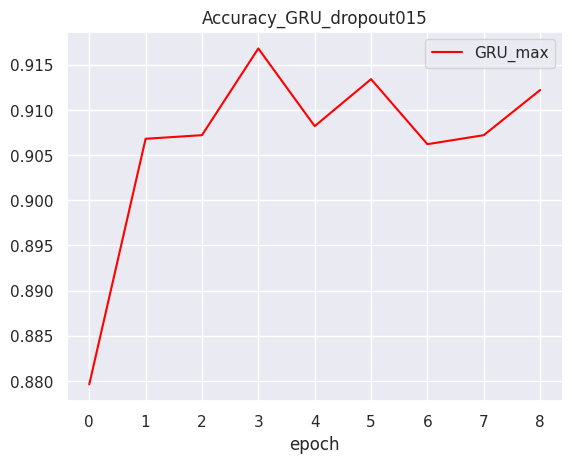

In [ ]:
for (name, values), color in zip(losses_gru_dropout015.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_gru_dropout015[name][1:])), acc_gru_dropout015[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_gru_dropout015[name]) * 100):.2f}")

plt.title('Accuracy_GRU_dropout015')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
gru_model_max = models_gru_dropout015['GRU_max']

accuracy_max = evaluate(gru_model_max, eval_dataloader)
print(f"GRU_dropout015_max агрегация: {accuracy_max * 100:.2f}%")

GRU_dropout015_max агрегация: 91.08%


# Заметное улучшение качества при dropout=0.2! (91.20%)

In [ ]:
losses_gru_dropout02, acc_gru_dropout02, models_gru_dropout02 = train_model(
    model_class=CharLMGRU,
    model_name="GRU",
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    vocab=vocab,
    word2ind=word2ind,
    device=device,
    num_epoch=5,
    num_layers=2,
    aggregation_types=['max'],
    bidirectional=True,
    dropout=0.2
)


Starting training for GRU with max aggregation


Epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода GRU_max: 91.48


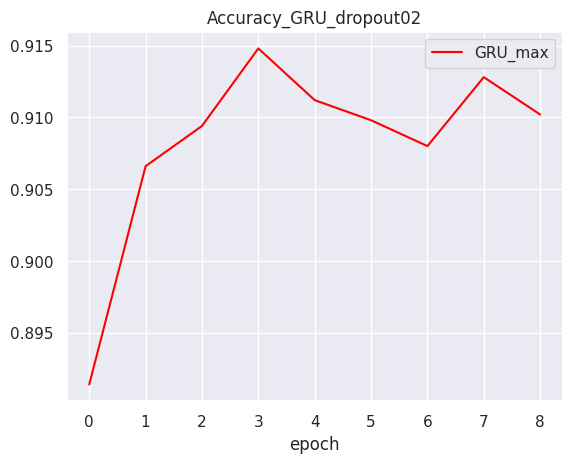

In [ ]:
for (name, values), color in zip(losses_gru_dropout02.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_gru_dropout02[name][1:])), acc_gru_dropout02[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_gru_dropout02[name]) * 100):.2f}")

plt.title('Accuracy_GRU_dropout02')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
gru_model_max = models_gru_dropout02['GRU_max']

accuracy_max = evaluate(gru_model_max, eval_dataloader)
print(f"GRU_dropout02_max агрегация: {accuracy_max * 100:.2f}%")

GRU_dropout02_max агрегация: 91.20%


In [ ]:
losses_gru_dropout03, acc_gru_dropout03, models_gru_dropout03 = train_model(
    model_class=CharLMGRU,
    model_name="GRU",
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    vocab=vocab,
    word2ind=word2ind,
    device=device,
    num_epoch=5,
    num_layers=2,
    aggregation_types=['max'],
    bidirectional=True,
    dropout=0.3
)


Starting training for GRU with max aggregation


Epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода GRU_max: 91.68


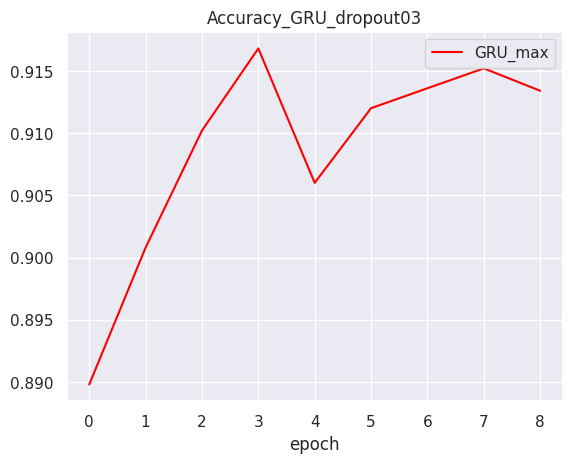

In [ ]:
for (name, values), color in zip(losses_gru_dropout03.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_gru_dropout03[name][1:])), acc_gru_dropout03[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_gru_dropout03[name]) * 100):.2f}")

plt.title('Accuracy_GRU_dropout03')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
gru_model_max = models_gru_dropout03['GRU_max']

accuracy_max = evaluate(gru_model_max, eval_dataloader)
print(f"GRU_dropout03_max агрегация: {accuracy_max * 100:.2f}%")

GRU_dropout03_max агрегация: 90.04%


**Более лучшее и стабильное качество при dropout = 0.2**

**5.1.2) Изменение параметра dropout для однослойной сети GRU_3.**

In [ ]:
losses_gru_3_dropout02, acc_gru_3_dropout02, models_gru_3_dropout02 = train_model(
    model_class=GRU_3,
    model_name="GRU",
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    vocab=vocab,
    word2ind=word2ind,
    device=device,
    num_epoch=5,
    num_layers=1,
    aggregation_types=['combined'],
    bidirectional=True,
    dropout=0.2
)


Starting training for GRU with combined aggregation


Epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода GRU_combined: 91.44


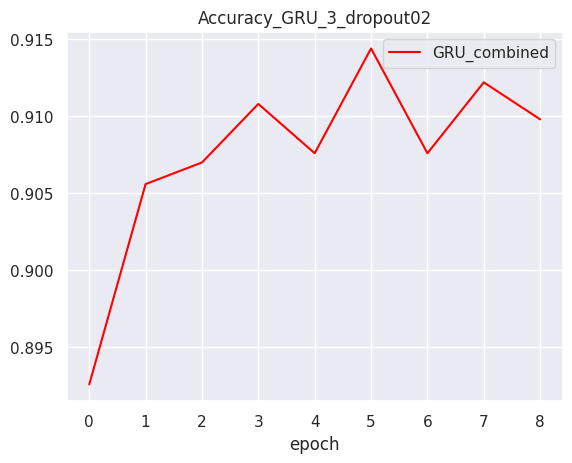

In [ ]:
for (name, values), color in zip(losses_gru_3_dropout02.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_gru_3_dropout02[name][1:])), acc_gru_3_dropout02[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_gru_3_dropout02[name]) * 100):.2f}")

plt.title('Accuracy_GRU_3_dropout02')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
gru_model_max = models_gru_3_dropout02['GRU_combined']

accuracy_max = evaluate(gru_model_max, eval_dataloader)
print(f"GRU_3_dropout02: {accuracy_max * 100:.2f}%")

GRU_3_dropout02: 90.56%


In [ ]:
losses_gru_3_dropout015, acc_gru_3_dropout015, models_gru_3_dropout015 = train_model(
    model_class=GRU_3,
    model_name="GRU",
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    vocab=vocab,
    word2ind=word2ind,
    device=device,
    num_epoch=5,
    num_layers=1,
    aggregation_types=['combined'],
    bidirectional=True,
    dropout=0.15
)


Starting training for GRU with combined aggregation


Epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

In [ ]:
gru_model_max = models_gru_3_dropout015['GRU_combined']

accuracy_max = evaluate(gru_model_max, eval_dataloader)
print(f"GRU_3_dropout015: {accuracy_max * 100:.2f}%")

GRU_3_dropout015: 90.74%


**5.2) Изменение размера hidden_dim**

На данный момент лучшее качество у однослойной нейронной сети GRU с max+mean+last агрегацией и dropout=0.1 (91.32% - на eval; 92% - на train)

Хуже качество у двухслойной сети GRU с max-агрегацией и dropout=0.2 (91.20% - на eval, 91.48 - на train).

Остановимся на первой сети и изменим для неё hidden_dim.

In [ ]:
def new_train_model(
    model_class,
    model_name,
    train_dataloader,
    eval_dataloader,
    vocab,
    word2ind,
    device,
    num_epoch=5,
    eval_steps=None,
    aggregation_types=['max', 'mean'],
    **model_kwargs
):
    if eval_steps is None:
        eval_steps = len(train_dataloader) // 2

    losses_type = {}
    acc_type = {}
    models = {}

    for aggregation_type in aggregation_types:
        print(f"\n{'='*50}")
        print(f"Starting training for {model_name} with {aggregation_type} aggregation")
        print(f"{'='*50}")

        losses = []
        acc = []

        model = model_class(
            hidden_dim=128,
            vocab_size=len(vocab),
            num_classes=4,
            aggregation_type=aggregation_type,
            **model_kwargs
        ).to(device)

        criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
        optimizer = torch.optim.Adam(model.parameters())

        for epoch in range(num_epoch):
            epoch_losses = []
            model.train()
            for i, batch in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch}:')):
                optimizer.zero_grad()
                logits = model(batch['input_ids'])
                loss = criterion(logits, batch['label'])
                loss.backward()
                optimizer.step()

                epoch_losses.append(loss.item())
                if i % eval_steps == 0:
                    model.eval()
                    accuracy = evaluate(model, eval_dataloader)
                    acc.append(accuracy)
                    model.train()

            losses.append(sum(epoch_losses) / len(epoch_losses))

        losses_type[f"{model_name}_{aggregation_type}"] = losses
        acc_type[f"{model_name}_{aggregation_type}"] = acc
        models[f"{model_name}_{aggregation_type}"] = model

    return losses_type, acc_type, models

In [ ]:
losses_gru_3_1layers_, acc_gru_3_1layers, models_gru_3_1layers = new_train_model(
    model_class=GRU_3,
    model_name="GRU",
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    vocab=vocab,
    word2ind=word2ind,
    device=device,
    num_epoch=5,
    num_layers=1,
    aggregation_types=['combined'],
    bidirectional=True
)


Starting training for GRU with combined aggregation


Epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода GRU_combined: 91.66


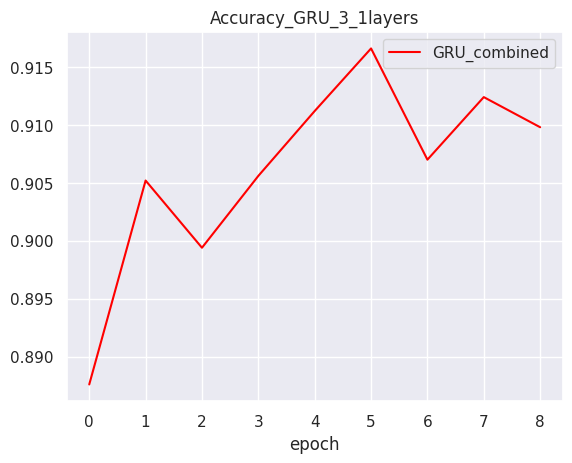

In [ ]:
for (name, values), color in zip(losses_gru_3_1layers_.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_gru_3_1layers[name][1:])), acc_gru_3_1layers[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_gru_3_1layers[name]) * 100):.2f}")

plt.title('Accuracy_GRU_3_1layers')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
gru_model_combined = models_gru_3_1layers['GRU_combined']

accuracy_combined = evaluate(gru_model_combined, eval_dataloader)
print(f"GRU_3_1layers_combined агрегация: {accuracy_combined * 100:.2f}%")

GRU_3_1layers_combined агрегация: 90.70%


Видим ухудшение качества при hidden_dim=128.
Можем попробовать поизменять, но времени не хватило:(

# Получение высокого качества

Лучший результат для однослойной нейронной сети GRU с max+mean+last агрегацией и dropout=0.1 (91.32% - на eval; 92% - на train_model).

In [ ]:
gru_model_combined = models_gru_3_1layers['GRU_combined']

accuracy_combined = evaluate(gru_model_combined, eval_dataloader)
print(f"GRU_3_1layers_combined агрегация: {accuracy_combined * 100:.2f}%")

GRU_3_1layers_combined агрегация: 91.32%


Немного хуже у двухслойной сети GRU с max- агрегацией и dropout=0.2 (91.20% - на eval, 91.48 - на train_model).

In [ ]:
gru_model_max = models_gru_dropout02['GRU_max']

accuracy_max = evaluate(gru_model_max, eval_dataloader)
print(f"GRU_dropout02_max агрегация: {accuracy_max * 100:.2f}%")

GRU_dropout02_max агрегация: 91.20%


# Отчёт по работе
Эксперименты
1) Смена модели на LSTM, GRU - результат лучше, чем у Vanilla RNN, наилучший у GRU

2) Увеличение количества рекуррентных слоёв у GRU - пробовали 1-3 слоя, лучший результат показала двухслойная сеть, однако однослойная сеть незначительно уступала двухслойной. В дальнейшем параметры проверялись отдельно для однослойной и двухслойной архитектур.

3) Добавление параметра bidirectional=True - наблюдается резкое увеличение качества

4) Изменение архитектуры после применения RNN - изначально качество лучше на моделях с max-агрегацией, чем с mean. Были опробованы комбинации max+last и max+mean+last агрегации. Для двухслойной GRU лучше показала себя max-агрегация, для однослойной - max+mean+last агрегация. Наилучшее качество достигнуто на однослойной GRU.

5) Подбор гиперпараметров

- Изменение dropout: для двухслойной лучше 0.2, для однослойной - 0.1

- Для однослойной модели предпринята попытка изменения hidden_dim (не хватило времени для полного исследования)

Cходимость качества от эпохи зачастую нестабильна. Так при увеличении слоёв она резко скачет. При небольшом увеличении dropout она более сглаженная.